# Introduction

In the following notebook, I will be modeling Airbnb Listings data to create a price predictor to better understand the data

**Read in libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\kishe\Miniconda3\envs\Airbnb_Listings_Analysis\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\Users\kishe\Miniconda3\envs\Airbnb_Listings_Analysis\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


**Set notebook preferences**

In [2]:
#Set options for pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Set options for numpy
np.set_printoptions(suppress=True)

#Set visualization preferences
plt.style.use('Solarize_Light2')

#Surpress warnings
import warnings
warnings.simplefilter('ignore')

**Read in data**

In [3]:
#Set path to data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Data\03_Processed'

#Read in training data and labels
df = pd.read_csv(path + '/2020_0715_Listings_Processed.csv', index_col=0)

**Data Overview**

In [4]:
#Display data and shape
print('Data shape: {}\n'.format(df.shape))
display(df.head())

Data shape: (116180, 12)



,accommodates,amenities_count,bedrooms,beds,cleaning_fee,guests_included,neighbourhood_cleansed_encoded,price,security_deposit,room_type,property_type,bed_type
0,3,26,1.000,2.000,100.000,2,253.859,170.000,100.000,Entire home/apt,Apartment,Real Bed
1,2,16,1.000,1.000,50.000,1,209.222,65.000,200.000,Private room,Apartment,Real Bed
3,6,33,2.000,3.000,125.000,1,253.859,255.000,0.000,Entire home/apt,Apartment,Real Bed
4,3,34,1.000,2.000,50.000,2,215.286,139.000,0.000,Private room,Condominium,Real Bed
5,2,23,1.000,1.000,50.000,1,238.334,135.000,2.000,Private room,House,Real Bed


### Data Preparation

**Split data into training and test sets**

In [5]:
#Seperate labels from data
X = df.drop('price', axis = 1)
y = df['price']

#Check
print('X shape:{}\ny shape:{}'.format(X.shape,y.shape))

X shape:(116180, 11)
y shape:(116180,)


In [6]:
#Import splitter
from sklearn.model_selection import train_test_split

#Split Data
X_train, X_test, y_train, y_test =  train_test_split(
                                    X,y, test_size = .2, random_state = 42)

#Check
print('Training data:{} | Training labels:{}'.format(X_train.shape,y_train.shape))
print('Test data:{} | Test labels:{}'.format(X_test.shape,y_test.shape))

Training data:(92944, 11) | Training labels:(92944,)
Test data:(23236, 11) | Test labels:(23236,)


# Model Development 

## Build Preprocessor

In [8]:
#Read in Libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict

#Init column transformer for data type
numeric_transformer = Pipeline([('scaler', MinMaxScaler())])
categorical_transformer = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])

#Subset numeric and cat features
num_features = X_train.select_dtypes(include=['int64','float64']).columns
cat_features = X_train.select_dtypes(include='object').columns

#Store column transform for pipeline
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_features),
                                              ('cat', categorical_transformer, cat_features)],
                                             n_jobs=-1,)

## Build pipeline with base model: DecisionTreeRegressor

In [8]:
#Init base model as regressor
regressors = DecisionTreeRegressor(random_state=12, max_depth=10)

#Init pipe
pipe = Pipeline([('preprocessor', preprocessor),
                ('model', regressors)])

**Make and Evaluate Predictions**

Base DecisionTreeRegressor Evaluation Metrics:
R2: 0.6779558155333093
MAE: 34.87246734250352 
MSE: 2454.6253628220547
RMSE: 49.54417587186263


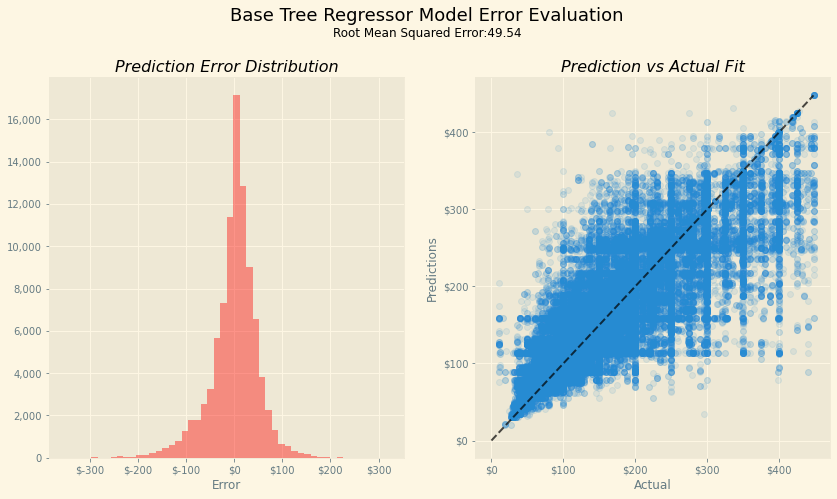

In [10]:
#Read in libraries from local machine
from Model_Evaluation import regression_metrics, prediction_error_df, prediction_fit_eval

#Implement model
preds = cross_val_predict(pipe, X_train,y_train, n_jobs=-1)

#Evaluate
base_metrics = regression_metrics('Base DecisionTreeRegressor', preds, y_train)

#View Error distribution and fit
base_errors = prediction_error_df(preds, y_train)
prediction_fit_eval(base_errors, model_name='Base Tree Regressor Model', rmse = base_metrics['rmse']);

#Save figure

In [14]:
#Display error dataframe
display(base_errors.sort_values(by = 'error_%', ascending= False).head(10))

,predictions,actual,error,error_%
95835,204.123,10.000,194.123,1941.232
37594,174.477,10.000,164.477,1644.773
108368,158.708,10.000,148.708,1487.084
31737,158.708,10.000,148.708,1487.084
70617,158.563,10.000,148.563,1485.630
76296,158.563,10.000,148.563,1485.630
87218,158.563,10.000,148.563,1485.630
97983,158.563,10.000,148.563,1485.630
81099,158.441,10.000,148.441,1484.408
92207,158.441,10.000,148.441,1484.408


# Test Ensemble and Boosting Methods

**Read in libraries**

In [37]:
#Import Libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

**Initialize pipeline components**

Will create a list of regression models w/ a corresponding list of parameters to be fit into a pipeline. Parameters will be brief and we'll later optimize the best performing model. 

In [38]:
#Create a list of model names to be used in a print funtion later when aggregating model evaluation metrics
model_names = [
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'AdaBoostRegressor',
    'ExtraTreesRegressor',
    'XGBRegressor',
]

#Init models into a list to loop over in pipeline to evaluate all base model performances
regressors = [
    RandomForestRegressor(random_state = 42, n_jobs=-1),
    GradientBoostingRegressor(random_state = 42,),
    AdaBoostRegressor(random_state = 42,),
    ExtraTreesRegressor(random_state = 42, n_jobs=-1),
    XGBRegressor(random_state = 42, n_jobs=-1)
]

**Build preliminary pipeline, evaluate results, and select model for futher development**

In [ ]:
#Implement pipe that tests evaluation metrics for all regressors
for name,regressor in zip(model_names, regressors):
    pipe.steps.pop(1) #Delete previous model in pipeline
    pipe.steps.append(['model',regressor]) #Add new model

    predictions = cross_val_predict(pipe, X_train, y_train, n_jobs=-1)
 
    #Evaluate
    regression_metrics(name,preds, y_train)

Without much tuning, our best models for this data set were RandomForestRegressor and the ExtraTreesRegressor. We'll go with the RandomForestRegresor to optimize for our purposes.

### Tune Hyperparameters of RandomForest

**RandomSearch CV**

In [ ]:
#Init libraries
from sklearn.model_selection import RandomizedSearchCV

#Set list with evaluation metrics for RandomizedSearchCV
scoring = ['r2','neg_mean_absolute_error','neg_mean_squared_error']

#Create list of model names for later loop
model_names = [
    'RandomForestRegressor',
    ]

#Init models 
regressor = RandomForestRegressor()

#Init parameters for RandomSearchCV evaluation to search over
parameters = [
    {'model__n_estimators':[200,300],
    'model__max_depth':[15,20,25],
    'model__max_features': ['auto', 'sqrt'],
    'model__random_state' : [42], 
    'model__n_jobs': [-1]
    }]

In [ ]:
#Create pipeline with parameter grid to search over base models(randomsearch cv)
for name, regressor, parameter in zip(model_names, regressors, parameters):
    pipe.steps.pop(1) #Delete previous model in pipeline
    pipe.steps.append(['model',regressor]) #Add new model
    
    reg = RandomizedSearchCV(pipe, param_distributions=parameter, n_jobs=-1, scoring=scoring, refit='neg_mean_squared_error')
    reg.fit(X_train, y_train)
    
    print("{} Random Search Results:".format(name))
    print('Avg RMSE:',np.mean(np.sqrt(-1 * (reg.cv_results_['mean_test_neg_mean_squared_error']))))
    print('Avg MAE:',np.mean(-1 * reg.cv_results_['mean_test_neg_mean_absolute_error']))
    r2 = np.mean(reg.cv_results_['mean_test_r2'])
    print('Avg R2:',r2)
    adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    print('Avg Adjusted R2:',adj_r2)
    print("\n The best estimator across ALL searched params:\n", reg.best_estimator_)
    print("\n The best parameters across searched parameters:\n", reg.best_params_)
    print("========================================================")

**GridSearch CV**

In [50]:
#Init parameters for RandomSearchCV evaluation to search over
parameters = [
    {'model__n_estimators':[300, 400, 500],
    'model__max_depth':[13,15, 17],
    'model__learning_rate': [.1],
    'model__random_state' : [42], 
    'model__n_jobs': [-1]}
]

In [51]:
#Create pipeline with parameter grid to search over XGBRegressor 

pipe = Pipeline([('model',XGBRegressor(random_state = 42, n_jobs = -1))])
rand_xbr = RandomizedSearchCV(pipe, param_distributions=parameters, n_jobs=-1, scoring=scoring, refit='neg_mean_squared_error')
rand_xbr.fit(X_train_transformed, y_train)
print("XGBRegressor Random Search Results:")
print('RMSE:',np.mean(np.sqrt(-1 * (rand_xbr.cv_results_['mean_test_neg_mean_squared_error']))))
print('MAE:',np.mean(-1 * rand_xbr.cv_results_['mean_test_neg_mean_absolute_error']))
print('R2:',np.mean(rand_xbr.cv_results_['mean_test_r2']))
print("\n The best estimator across ALL searched params:\n", rand_xbr.best_estimator_)
print("\n The best parameters across searched parameters:\n", rand_xbr.best_params_)

XGBRegressor Random Search Results:
RMSE: 15.125169645337053
MAE: 5.492793147794266
R2: 0.9721892029756335

 The best estimator across ALL searched params:
 Pipeline(memory=None,
         steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=-1, num_parallel_tree=1,
                              objective='reg:squarederror', random_state=42,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, 

**Inspect Feature Importance of Tuned RandomForest Regressor**

### Build Final Pipeline

In [54]:
#Import GridSearchCV
from sklearn.model_selection import GridSearchCV

#Set final params of XGBRegressor
final_params=  {'model__n_estimators': [500], 
                'model__max_depth': [13], 
                'model__learning_rate': [0.1]}



#Build final pipeline
final_pipe = Pipeline([('selector', selector),
                      ('model', XGBRegressor(random_state = 42, n_jobs = -1))])

#Init GridSearchCV and fit to training data
grid = GridSearchCV(final_pipe, final_params, cv =5, n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selector',
                                        SelectFromModel(estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features=None,
                                                                                        max_leaf_nodes=None,
                                                                                        min_impurity_decrease=0.0,
                                                                                        min_impurity_split=None,
                                                                                        min_samples_leaf=1,
     

In [57]:
#Set path for test data and tunes pipeline
path_test = r'C:\Users\kishe\Documents\Data Science\Projects\Python\In Progress\Airbnb - San Francisco\Data\04_Test_Data'
path_pipe = r'C:\Users\kishe\Documents\Data Science\Projects\Python\In Progress\Airbnb - San Francisco\Project_Codes\05_Evaluation'

#Write pipeline
from sklearn.externals import joblib
joblib.dump(grid.best_estimator_, path_pipe + '/xgbr_regressor.pkl', compress = 1)

#Write test data
X_test.to_csv(path_test + '/2020_0614_Listings_Test_Data.csv')
y_test.to_csv(path_test + '/2020_0614_Listings_Test_Labels.csv')